# %% [markdown]

 # Data Preparation and Cleaning Pipeline

 This notebook transforms the raw dataset into a clean, structured format suitable for model fine-tuning. We'll address data quality issues, normalize entity formats, and prepare the data for both training and evaluation phases.

 ## Setup environment and import necessary libraries

In [ ]:
# %%

from notebook_config import DATASETS_DIR
import pandas as pd
import matplotlib.pyplot as plt
from markdownify import markdownify as md

# %% [markdown]

 ## Load and Preview Raw Dataset

 Load the full dataset into a DataFrame and preview its structure to understand the current state of the data before applying any transformations. This establishes our baseline for measuring the impact of our cleaning operations.

In [ ]:
# %%

df = pd.read_csv(DATASETS_DIR / 'full_data.csv')
df.head()

,Unnamed: 0,urls,text,persons,organizations,themes,locations
0,0,https://edition.cnn.com/2022/08/01/politics/go...,"""articleBody"":""A federal judge has ruled again...","Louie Gohmert,161;Timothy Kelly,493;Andrew Cly...","Dc District Court,439","TAX_POLITICAL_PARTY_REPUBLICANS,56;USPEC_POLIT...","Georgia,Pennsylvania,Texas"
1,1,https://www.cnn.com/2022/08/01/media/texas-dpr...,"""articleBody"":""More than a dozen major news or...","Laura Lee Prather,1177;Haynes Boone,1220;Nicol...","Texas Department Of Public Safety,128;Texas De...","TRIAL,82;TRIAL,551;DELAY,477;DELAY,2393;EDUCAT...","Robb Elementary School,Texas Department Of Pub..."
2,2,https://www.cnn.com/2022/08/01/politics/pact-a...,"""articleBody"":""Comedian Jon Stewart and vetera...","Pat Toomey,1802;Kate Bolduan,1114;Matt Zeller,...","Senate Majority Leader Chuck Schumer,1635;Whil...","TAX_POLITICAL_PARTY_REPUBLICANS,742;TAX_POLITI...","Iraq,America,Pennsylvania"
3,3,https://www.cnn.com/2022/08/01/politics/gop-la...,"""articleBody"":""A federal judge has ruled again...","Louie Gohmert,161;Timothy Kelly,493;Andrew Cly...","Dc District Court,439","TAX_POLITICAL_PARTY_REPUBLICANS,56;USPEC_POLIT...","Georgia,Pennsylvania,Texas"
4,4,https://www.cnn.com/2022/08/01/politics/vetera...,"""articleBody"":""A version of this story appears...","Pat Toomey,1342;Joe Manchin,4990;Paul Leblanc,...","Union On,2356;Senate Republicans,370;Veterans ...","EPU_POLICY_GOVERNMENT,344;EPU_POLICY_GOVERNMEN...","Pennsylvania,Capitol Hill,West Virginia,Americ..."


# %% [markdown]

 ## Data Quality Assessment - Content Format Analysis

 Initial assessment: count entries with raw HTML or JSON wrappers. This analysis reveals:
 - **HTML entries**: Articles wrapped in HTML tags that need conversion to plain text
 - **JSON entries**: Articles wrapped in JSON format with "articleBody" fields that need extraction

 These counts help us understand the scope of preprocessing required and ensure we don't lose any data during cleaning.

In [ ]:
# %%

num_html = df['text'].str.startswith('<html').sum()
num_json = df['text'].str.startswith('"articleBody":"').sum()
print(f"Rows starting with HTML: {num_html}")
print(f"Rows starting with JSON articleBody: {num_json}")

Rows starting with HTML: 118
Rows starting with JSON articleBody: 574


# %% [markdown]

 ## Entity Format Standardization

 Prepare data for fine-tuning by normalizing entity formats:
 - **Fill missing values**: Ensures consistency in text processing by replacing NaN values with empty strings
 - **Extract entity names**: Remove ID metadata from entity fields, keeping only the actual names
 - **Standardize delimiters**: Convert all entity lists to semicolon-separated format for consistency

 This step focuses the model training on raw text rather than metadata, improving generalization.

In [ ]:
# %%

df_prep = df.copy().fillna('')
df_prep['persons'] = (
    df_prep['persons']
    .apply(lambda x: ';'.join([e.split(',')[0] for e in x.split(';')]))
)
df_prep['organizations'] = (
    df_prep['organizations']
    .apply(lambda x: ';'.join([e.split(',')[0] for e in x.split(';')]))
)
df_prep['locations'] = (
    df_prep['locations']
    .apply(lambda x: ';'.join(x.split(',')))
)
df_prep.head()

,Unnamed: 0,urls,text,persons,organizations,themes,locations
0,0,https://edition.cnn.com/2022/08/01/politics/go...,"""articleBody"":""A federal judge has ruled again...",Louie Gohmert;Timothy Kelly;Andrew Clyde;Lloyd...,Dc District Court,"TAX_POLITICAL_PARTY_REPUBLICANS,56;USPEC_POLIT...",Georgia;Pennsylvania;Texas
1,1,https://www.cnn.com/2022/08/01/media/texas-dpr...,"""articleBody"":""More than a dozen major news or...",Laura Lee Prather;Haynes Boone;Nicole Carroll,Texas Department Of Public Safety;Texas Depart...,"TRIAL,82;TRIAL,551;DELAY,477;DELAY,2393;EDUCAT...",Robb Elementary School;Texas Department Of Pub...
2,2,https://www.cnn.com/2022/08/01/politics/pact-a...,"""articleBody"":""Comedian Jon Stewart and vetera...",Pat Toomey;Kate Bolduan;Matt Zeller;Jon Stewart,Senate Majority Leader Chuck Schumer;While Sen...,"TAX_POLITICAL_PARTY_REPUBLICANS,742;TAX_POLITI...",Iraq;America;Pennsylvania
3,3,https://www.cnn.com/2022/08/01/politics/gop-la...,"""articleBody"":""A federal judge has ruled again...",Louie Gohmert;Timothy Kelly;Andrew Clyde;Lloyd...,Dc District Court,"TAX_POLITICAL_PARTY_REPUBLICANS,56;USPEC_POLIT...",Georgia;Pennsylvania;Texas
4,4,https://www.cnn.com/2022/08/01/politics/vetera...,"""articleBody"":""A version of this story appears...",Pat Toomey;Joe Manchin;Paul Leblanc;Jake Tappe...,Union On;Senate Republicans;Veterans Affairs;U...,"EPU_POLICY_GOVERNMENT,344;EPU_POLICY_GOVERNMEN...",Pennsylvania;Capitol Hill;West Virginia;Americ...


# %% [markdown]

 ## Text Content Cleaning and Normalization

 Clean text column by addressing different content formats:
 - **HTML conversion**: Convert HTML segments to Markdown format, preserving readability while removing markup tags
 - **JSON extraction**: Extract plain text from JSON-wrapped "articleBody" fields, removing JSON structure
 - **Tag removal**: Strip specific HTML tags like `<a>` links that don't contribute to content understanding

 This ensures all text is in a consistent, clean format suitable for NLP model training.

In [ ]:
# %%

df_clean = df_prep.copy()
# Convert HTML segments to Markdown, removing <a> tags
html_idx = df_clean['text'].str.startswith('<html')
df_clean.loc[html_idx, 'text'] = (
    df_clean.loc[html_idx, 'text']
    .apply(lambda x: md(x, strip=['a']))
)
# Extract plain text from JSON-wrapped fields
json_idx = df_clean['text'].str.startswith('"articleBody":"')
df_clean.loc[json_idx, 'text'] = (
    df_clean.loc[json_idx, 'text']
    .apply(lambda x: x.split('"articleBody":"')[1].split('"')[0])
)
df_clean.head(15)

,Unnamed: 0,urls,text,persons,organizations,themes,locations
0,0,https://edition.cnn.com/2022/08/01/politics/go...,A federal judge has ruled against House Republ...,Louie Gohmert;Timothy Kelly;Andrew Clyde;Lloyd...,Dc District Court,"TAX_POLITICAL_PARTY_REPUBLICANS,56;USPEC_POLIT...",Georgia;Pennsylvania;Texas
1,1,https://www.cnn.com/2022/08/01/media/texas-dpr...,More than a dozen major news organizations hav...,Laura Lee Prather;Haynes Boone;Nicole Carroll,Texas Department Of Public Safety;Texas Depart...,"TRIAL,82;TRIAL,551;DELAY,477;DELAY,2393;EDUCAT...",Robb Elementary School;Texas Department Of Pub...
2,2,https://www.cnn.com/2022/08/01/politics/pact-a...,Comedian Jon Stewart and veterans’ advocates o...,Pat Toomey;Kate Bolduan;Matt Zeller;Jon Stewart,Senate Majority Leader Chuck Schumer;While Sen...,"TAX_POLITICAL_PARTY_REPUBLICANS,742;TAX_POLITI...",Iraq;America;Pennsylvania
3,3,https://www.cnn.com/2022/08/01/politics/gop-la...,A federal judge has ruled against House Republ...,Louie Gohmert;Timothy Kelly;Andrew Clyde;Lloyd...,Dc District Court,"TAX_POLITICAL_PARTY_REPUBLICANS,56;USPEC_POLIT...",Georgia;Pennsylvania;Texas
4,4,https://www.cnn.com/2022/08/01/politics/vetera...,A version of this story appears in CNN’s What ...,Pat Toomey;Joe Manchin;Paul Leblanc;Jake Tappe...,Union On;Senate Republicans;Veterans Affairs;U...,"EPU_POLICY_GOVERNMENT,344;EPU_POLICY_GOVERNMEN...",Pennsylvania;Capitol Hill;West Virginia;Americ...
5,5,https://edition.cnn.com/2022/08/01/politics/bi...,President Joe Biden is still testing positive ...,Kevin Oconnor;Joe Biden,White House;White House;White House;White Hous...,"MEDIA_MSM,725;TAX_FNCACT_PHYSICIAN,163;GENERAL...",White House
6,6,https://www.cnn.com/2022/07/30/business/us-ban...,The fifth-largest commercial bank in the US wa...,Rohit Chopra,Consumer Financial Protection Bureau;Cnn;Cnn;U...,"TAX_ECON_PRICE,1858;ECON_INTEREST_RATES,1846;E...",New York;United States
7,7,https://www.cnn.com/2022/08/01/us/kentucky-man...,Nathan Day was up early Thursday morning helpi...,Irma Gayheart;Ella Prater,Cnn;Cnn,"NATURAL_DISASTER_FLOODING,601;NATURAL_DISASTER...",Knott County;Kentucky
8,8,https://www.cnn.com/2022/08/01/politics/trump-...,In Michigan’s jam-packed Republican primary fi...,Matthew Deperno;Garrett Soldano;Donald Trump;T...,Republican Party;Cnn;Cnn;Cnn,"TAX_FNCACT_CANDIDATES,510;TAX_FNCACT_CANDIDATE...",Michigan
9,9,https://www.cnn.com/2022/08/01/politics/joe-bi...,The United States killed al Qaeda leader Ayman...,Rabiaa Al-Zawahiri;Anwar Sadat;Al Qaeda;Al Qae...,White House;White House;Azhar University;Cnn;U...,"IDEOLOGY,1564;TAX_TERROR_GROUP_EGYPTIAN_ISLAMI...",White House;Azhar University;Soviet;Kenya;Riya...


# %% [markdown]

 ## Cleaning Validation

 Re-count entries after cleaning to verify that our transformations were successful:
 - **HTML remaining**: Should be 0 if all HTML was properly converted
 - **JSON remaining**: Should be 0 if all JSON wrappers were properly extracted

 This validation step ensures no data was lost or improperly processed during cleaning.

In [ ]:
# %%

pct_html_remaining = df_clean['text'].str.startswith('<html').sum()
pct_json_remaining = df_clean['text'].str.startswith('"articleBody":"').sum()
print(f"HTML entries remaining: {pct_html_remaining}")
print(f"JSON wrappers remaining: {pct_json_remaining}")

HTML entries remaining: 0
JSON wrappers remaining: 0


# %% [markdown]

 ## Dataset Splitting for Training and Evaluation

 Split the cleaned dataset into training and testing sets to enable proper model evaluation:
 - **50% split**: Ensures balanced datasets for both training and evaluation
 - **Fixed random seed**: Guarantees reproducible splits across different runs
 - **Stratified approach**: Maintains distribution of entity types across splits

 This separation is crucial for preventing data leakage and ensuring unbiased model performance assessment.

In [ ]:
# %%

from sklearn.model_selection import train_test_split
train_df, test_df = train_test_split(
    df_clean,
    test_size=0.5,
    random_state=42
)
print(f"Training size: {len(train_df)}, Testing size: {len(test_df)}")

Training size: 346, Testing size: 346


# %% [markdown]

 ## Token Distribution Analysis

 Analyze token distribution for training data using tiktoken to understand text length characteristics:
 - **Model-specific tokenization**: Uses GPT-4 tokenizer for accurate token counting
 - **Length distribution**: Helps set appropriate sequence length limits for model training
 - **Memory planning**: Informs batch size and model architecture decisions
 - **Outlier detection**: Identifies extremely long or short texts that might need special handling

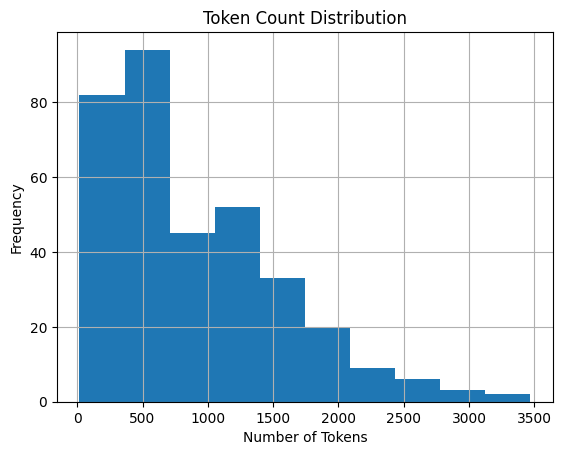

In [ ]:
# %%

import tiktoken
enc = tiktoken.encoding_for_model('gpt-4o')
train_df['num_tokens'] = train_df['text'].apply(lambda x: len(enc.encode(x)))
train_df['num_tokens'].hist()
plt.title('Token Count Distribution')
plt.xlabel('Number of Tokens')
plt.ylabel('Frequency')
plt.show()

# %% [markdown]

 ## Export Cleaned Datasets

 Save the cleaned and split datasets for use in model fine-tuning:
 - **Training dataset**: Contains the data used for model training with token counts
 - **Testing dataset**: Reserved for final model evaluation and performance assessment

 These files serve as the foundation for all subsequent model development and evaluation activities.

In [ ]:
# %%

train_df.to_csv(DATASETS_DIR / 'full_data_clean_finetune.csv', index=False)
test_df.to_csv(DATASETS_DIR / 'full_data_clean.csv', index=False)

# %% [markdown]

 ## Optional: Text File Export for Batch Processing

 (Optional) Export training text lines to a text file for batch fine-tuning scenarios where raw text input is preferred over structured CSV format. This can be useful for certain fine-tuning frameworks or when working with very large datasets.

In [ ]:
# %%

# with open(FILES_DIR / 'finetune_data.txt', 'w', encoding='utf-8') as f:
#     for line in train_df['text']:
#         f.write(line + '\n')